In [2]:
%pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 1.9 MB/s  0:00:37m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 2.1 MB/s  0:00:08m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install torch

  Using cached typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_c

In [6]:
%pip install pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 334.3 kB/s  0:00:22 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
import cv2
import numpy as np
import torch
from PIL import Image

In [9]:
%pip install open-clip-torch

  Using cached certifi-2026.1.4-py3-none-any.whl.metadata (2.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 16.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.3/553.3 kB 21.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 21.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 24.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.7/803.7 kB 22.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 23.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24/24 [open-clip-torch] [open-clip-torch]
Note: you may need to restart the kernel to use updated packages.


In [23]:
import open_clip

device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "ViT-B-32"
pretrained = "laion2b_s34b_b79k"

model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

model = model.to(device).eval()

print("Device:", device)

Device: cuda


In [24]:
PROMPTS = [
    "a passport data page with photo and text",
    "a passport biodata page",
    "a passport identity page",
    "an open passport showing the identification page",
    "a photo ID page in a passport",
]

In [25]:
@torch.no_grad()
def build_text_features(prompts):
    text = tokenizer(prompts).to(device)
    text_feat = model.encode_text(text)
    text_feat = text_feat / text_feat.norm(dim=-1, keepdim=True)
    return text_feat

TEXT_FEATURES = build_text_features(PROMPTS)

In [26]:
@torch.no_grad()
def clip_scores_bgr_batch(crops_bgr, text_features, batch_size=32):
    """
    crops_bgr: list of BGR np.ndarray crops
    returns: np.ndarray scores (N,)
    """
    scores = []
    for i in range(0, len(crops_bgr), batch_size):
        batch = crops_bgr[i:i+batch_size]

        imgs = torch.stack([
            preprocess(Image.fromarray(cv2.cvtColor(c, cv2.COLOR_BGR2RGB)))
            for c in batch
        ]).to(device)

        img_feat = model.encode_image(imgs)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

        sims = img_feat @ text_features.T           
        batch_scores = sims.max(dim=1).values       
        scores.append(batch_scores.float().cpu().numpy())

    return np.concatenate(scores, axis=0)

In [27]:
def generate_windows_ar(H, W,
                        area_fracs=(0.45, 0.38, 0.32, 0.26, 0.22),
                        ratios=(1.25, 1.35, 1.45, 1.6, 1.0),
                        stride=0.22):
    """
    Windows by area fraction + aspect ratios.
    ratio = win_w / win_h
    """
    windows = []
    for a in area_fracs:
        for r in ratios:
            win_w = int(np.sqrt(a * W * H * r))
            win_h = int(np.sqrt(a * W * H / r))

            if win_w < 200 or win_h < 200 or win_w > W or win_h > H:
                continue

            sx = max(1, int(win_w * stride))
            sy = max(1, int(win_h * stride))

            for y0 in range(0, H - win_h + 1, sy):
                for x0 in range(0, W - win_w + 1, sx):
                    windows.append((x0, y0, x0 + win_w, y0 + win_h))
    return windows



In [28]:
def resize_keep_aspect(img, max_w=900):
    h, w = img.shape[:2]
    if w <= max_w:
        return img, 1.0
    scale = max_w / w
    new_size = (int(w * scale), int(h * scale))
    return cv2.resize(img, new_size, interpolation=cv2.INTER_AREA), scale


In [29]:
def locate_data_page_zero_shot(
    img_bgr,
    prompts=PROMPTS,
    target_ratio=1.4,
    max_search_w=640,     
    batch_size=32         
):
    H, W = img_bgr.shape[:2]

    # search on a smaller image for speed
    small, scale = resize_keep_aspect(img_bgr, max_w=max_search_w)
    Hs, Ws = small.shape[:2]

    windows = generate_windows_ar(Hs, Ws)
    if not windows:
        return img_bgr, {"reason": "no_windows_generated"}

    # build crop list
    crops = [small[y0:y1, x0:x1] for (x0, y0, x1, y1) in windows]

    # use cached text features 
    text_features = TEXT_FEATURES if prompts is PROMPTS else build_text_features(prompts)

    # batch score all crops
    scores = clip_scores_bgr_batch(crops, text_features, batch_size=batch_size)

    # pick best with penalties 
    best = None
    for score, (x0, y0, x1, y1) in zip(scores, windows):
        area = (x1 - x0) * (y1 - y0) / (Hs * Ws)
        r = (x1 - x0) / ((y1 - y0) + 1e-6)
        ar_pen = abs(np.log(r / target_ratio))

        score_adj = float(score) - 0.03 * area - 0.08 * ar_pen

        if best is None or score_adj > best["score_adj"]:
            best = {
                "x0": x0, "y0": y0, "x1": x1, "y1": y1,
                "score": float(score),
                "score_adj": float(score_adj),
                "area": float(area),
                "ratio": float(r),
            }

    # map bbox back to original coords
    inv = 1.0 / scale
    x0 = int(best["x0"] * inv); y0 = int(best["y0"] * inv)
    x1 = int(best["x1"] * inv); y1 = int(best["y1"] * inv)

    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(W, x1); y1 = min(H, y1)

    crop_best = img_bgr[y0:y1, x0:x1].copy()

    debug = {
        "bbox": (x0, y0, x1, y1),
        "score": best["score"],
        "score_adj": best["score_adj"],
        "area_frac": best["area"],
        "win_ratio": best["ratio"],
        "num_windows": len(windows),
        "search_max_w": max_search_w,
        "batch_size": batch_size,
        "device": str(device),
    }
    return crop_best, debug

In [38]:
def expand_bbox_asym(bbox, W, H,
                     pad_left=0.02, pad_right=0.55,
                     pad_top=0.00,  pad_bottom=1.70,
                     shift_x=0.02,  shift_y=0.48):
    """
    pad_* are fractions of bbox width/height.
    shift_* moves the box right/down by a fraction of bbox width/height.
    """
    x0, y0, x1, y1 = bbox
    bw = x1 - x0
    bh = y1 - y0

    # shift the bbox
    dx = int(shift_x * bw)
    dy = int(shift_y * bh)
    x0 += dx; x1 += dx
    y0 += dy; y1 += dy

    # asymmetric padding
    x0 = int(x0 - pad_left * bw)
    x1 = int(x1 + pad_right * bw)
    y0 = int(y0 - pad_top * bh)
    y1 = int(y1 + pad_bottom * bh)

    # clamp
    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(W, x1); y1 = min(H, y1)
    return (x0, y0, x1, y1)




In [39]:
def order_quad_points(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1).reshape(-1)

    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]

    return np.array([tl, tr, br, bl], dtype=np.float32)

def four_point_warp(image, quad, out_w=1000, out_h=700):
    quad = order_quad_points(quad)
    dst = np.array([
        [0, 0],
        [out_w - 1, 0],
        [out_w - 1, out_h - 1],
        [0, out_h - 1]
    ], dtype=np.float32)

    M = cv2.getPerspectiveTransform(quad, dst)
    warped = cv2.warpPerspective(image, M, (out_w, out_h))
    return warped


In [ ]:
def refine_to_page_boundary_threshold(crop_bgr):
    gray = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2GRAY)

    # Normalize + smooth
    gray = cv2.bilateralFilter(gray, 9, 75, 75)
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # Invert so page content becomes foreground-ish
    thr = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 35, 10
    )

    # Merge text blocks into one region 
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, np.ones((9,9), np.uint8), iterations=2)
    thr = cv2.dilate(thr, np.ones((7,7), np.uint8), iterations=1)

    contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return crop_bgr, {"refine": "no_contours"}

    # Biggest contour as page candidate
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    H, W = crop_bgr.shape[:2]

    if area < 0.20 * (H * W):
        # If too small, likely grabbed just text area; return original crop
        return crop_bgr, {"refine": "contour_too_small", "area": float(area)}

    rect = cv2.minAreaRect(cnt)                 
    box = cv2.boxPoints(rect).astype(np.float32)

    warped = four_point_warp(crop_bgr, box, out_w=1000, out_h=700)
    return warped, {"refine": "minAreaRect_warped", "area": float(area)}


In [41]:
def post_trim_warp(warped, trim_top=0.10, trim_bottom=0.00):
    h, w = warped.shape[:2]
    y0 = int(h * trim_top)
    y1 = int(h * (1.0 - trim_bottom))
    return warped[y0:y1, :]


In [44]:
import time

img = cv2.imread("IMG_7415.jpeg")
t0 = time.time()

region, dbg1 = locate_data_page_zero_shot(img, max_search_w=640, batch_size=32)

t1 = time.time()
print("Locator time:", t1 - t0, "sec")
print("Debug:", dbg1)

Locator time: 1.7791972160339355 sec
Debug: {'bbox': (0, 878, 2716, 2891), 'score': 0.3775020241737366, 'score_adj': 0.3611179371366557, 'area_frac': 0.4486921160609613, 'win_ratio': 1.3497652550474994, 'num_windows': 376, 'search_max_w': 640, 'batch_size': 32, 'device': 'cuda'}


In [14]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Expanded bbox: (0, 1844, 3024, 4032)
Refine: {'refine': 'minAreaRect_warped', 'area': 3512121.0}


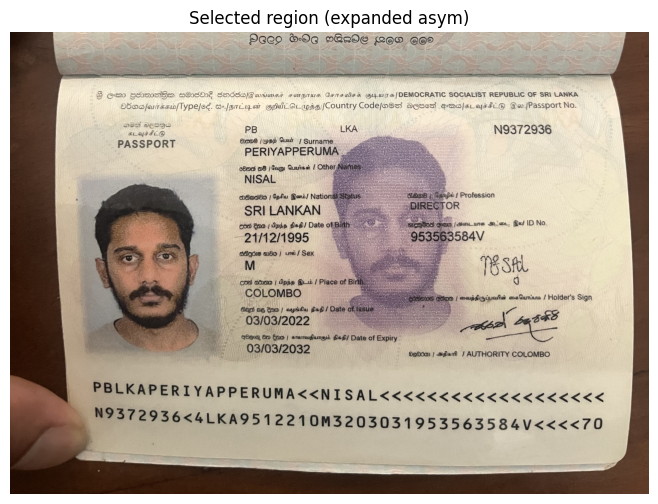

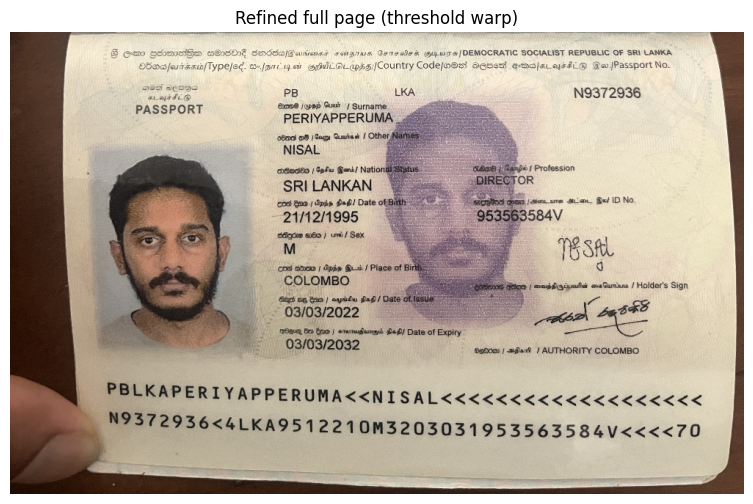

In [45]:
img = cv2.imread("IMG_7415.jpeg")
H, W = img.shape[:2]

region, dbg1 = locate_data_page_zero_shot(img)

bbox2 = expand_bbox_asym(
    dbg1["bbox"], W, H,
    pad_left=0.02, pad_right=0.55,
    pad_top=0.00,  pad_bottom=1.50,   
    shift_x=0.02,  shift_y=0.48
)

x0,y0,x1,y1 = bbox2
region2 = img[y0:y1, x0:x1].copy()

page, dbg2 = refine_to_page_boundary_threshold(region2)

page = post_trim_warp(page, trim_top=0.10, trim_bottom=0.00)

print("Expanded bbox:", bbox2)
print("Refine:", dbg2)

 
import matplotlib.pyplot as plt
def show_bgr(bgr, title=""):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

show_bgr(region2, "Selected region (expanded asym)")
show_bgr(page, "Refined full page (threshold warp)")

